In [18]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display
import random

In [19]:
DATA_PATH = "../data/"
DATASET_FILENAME = "spotify_dataset.csv"
DATASET_PATH = f"{DATA_PATH}{DATASET_FILENAME}"

In [20]:
# Errors are found: example: "7511e45f2cc6f6e609ae46c15506538c","Glenn Gould",""Kyllikki" - Three Lyric Pieces for Piano, Op. 41 - II. Andantino","Instrumenal - Home Listens"
# No warnings on bad lines are found

In [21]:
# Sample the dataset (aleatory) to work faster
SAMPLE_RAW_DATASET = 0.2

In [22]:
df_playlists = pd.read_csv(DATASET_PATH, on_bad_lines="skip", skiprows=lambda i: random.random() > SAMPLE_RAW_DATASET and i > 0)

In [23]:
with open(f'{DATASET_PATH.replace("csv","parquet")}', mode='wb') as f_out:
    df_playlists.to_parquet(f_out)

In [24]:
df_playlists.head()

,user_id,"""artistname""","""trackname""","""playlistname"""
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Lissie,All Be Okay,HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Paul McCartney,Band On The Run,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,The Coronas,Decision Time,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Cocktail Slippers,Goodtimes,HARD ROCK 2010


In [25]:
df_playlists.columns = df_playlists.columns.str.replace("\"", "") \
  .str.strip() \
  .str.replace("_","") \
  .str.replace("name","")

# EDA

In [26]:
df_playlists.shape

(2576680, 4)

In [27]:
df_playlists.dtypes

userid      object
artist      object
track       object
playlist    object
dtype: object

In [28]:
df_playlists.describe()

,userid,artist,track,playlist
count,2576680,2569973,2576664,2576418
unique,15412,149333,784974,142764
top,4398de6902abde3351347b048fcdc287,Daft Punk,Intro,Starred
freq,59045,7143,1390,266819


In [29]:
df_playlists.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2576680 entries, 0 to 2576679
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   userid    2576680 non-null  object
 1   artist    2569973 non-null  object
 2   track     2576664 non-null  object
 3   playlist  2576418 non-null  object
dtypes: object(4)
memory usage: 78.6+ MB


In [30]:
# Check suplicated and fix nulls

In [31]:
df_playlists.duplicated().sum()

0

In [32]:
df_playlists.isnull().sum()

userid         0
artist      6707
track         16
playlist     262
dtype: int64

Remove any record with missing artist

In [33]:
df_playlists = df_playlists.dropna(subset=["artist"])


<AxesSubplot: >

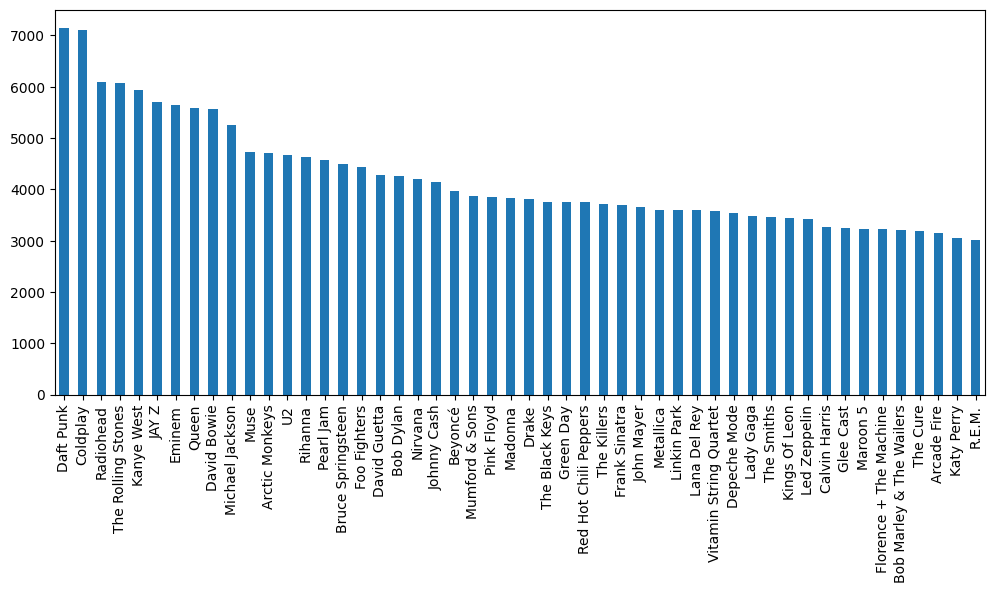

In [34]:
plt.figure()
df_playlists["artist"].value_counts().head(50).plot(kind="bar", figsize=[12,5])

<AxesSubplot: >

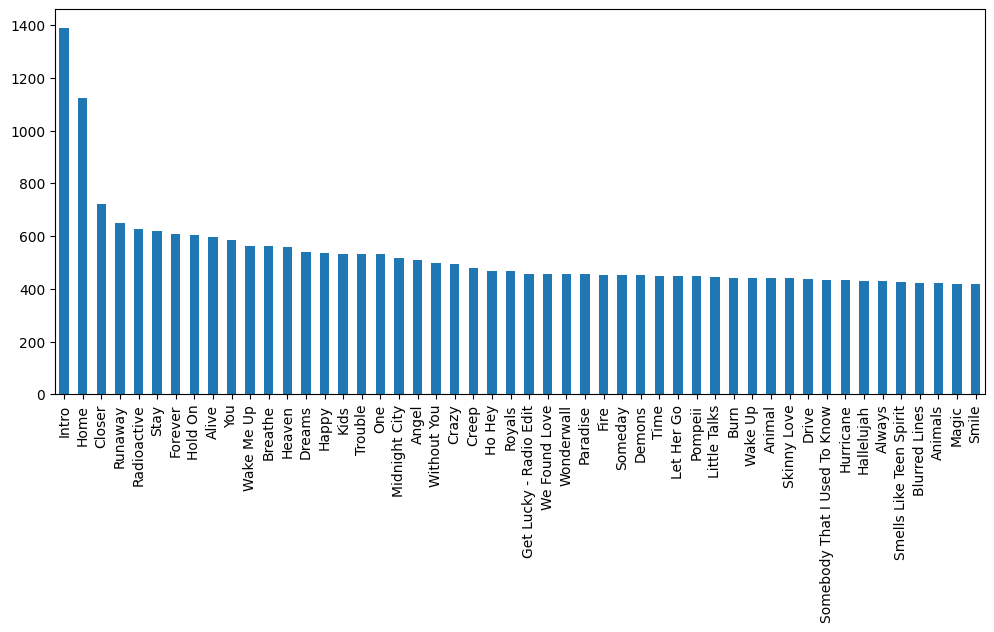

In [35]:
df_playlists["track"].value_counts().head(50).plot(kind="bar", figsize=[12,5])

Recommending by track may be confusing, since there are different actual songs with the same name.  Maybe a more complex algorythm considering the characteristics of the track could suitable?

<AxesSubplot: >

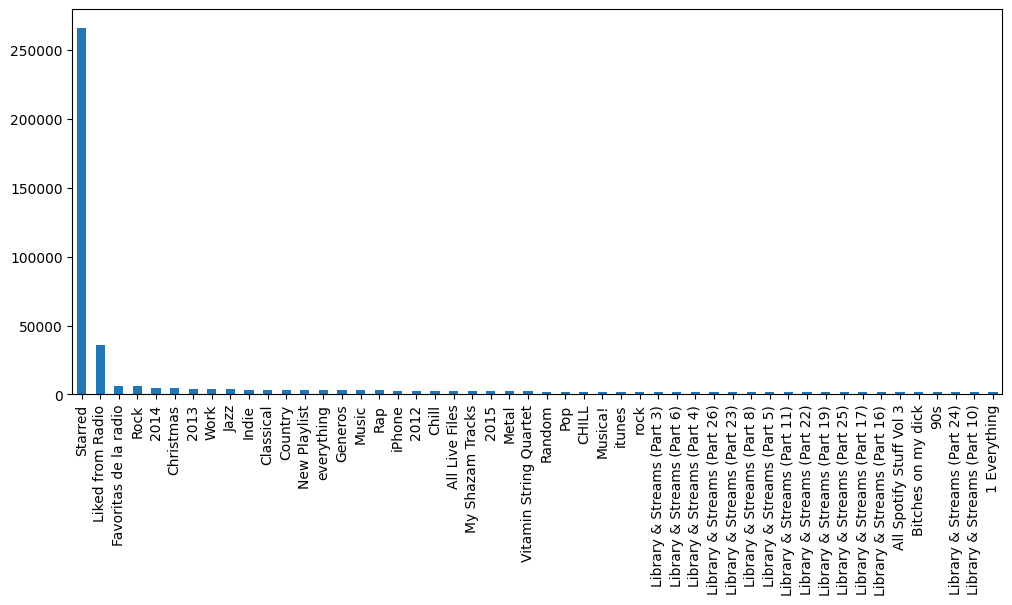

In [36]:
df_playlists["playlist"].value_counts().head(50).plot(kind="bar", figsize=[12,5])

Some default playlists shall be discarded, if we recommend playlists. I don't think its worth to recommend playlists, instead artists should work better. 

Let's check if there are heay users: There are

In [37]:
df_playlists["userid"].value_counts().head(10)

4398de6902abde3351347b048fcdc287    59044
7ee2b92c5bcf6133b8132363e5bda960    18299
99deafd9b792af8e6a535483088faef2    13090
fa849dabeb14a2800ad5130907fc5018    12042
6b85a8076b4f3b1036ef15f09e2feeeb     7944
ed140fce438f59e6e07e5ee7bd726692     6642
2fa1f93e57cfe2f6c4456e98da54061c     6331
c0efe4e704a37894150489b25eac9042     5075
c2d2fed26e858f82fdd8ac2e791cab1f     5040
c410ee930bd5f0e4893632503ec17b05     4981
Name: userid, dtype: int64

In [38]:
df_playlists[df_playlists["userid"] == "4398de6902abde3351347b048fcdc287"].describe()

,userid,artist,track,playlist
count,59044,59044,59044,59044
unique,1,17130,51022,29
top,4398de6902abde3351347b048fcdc287,Boyce Avenue,Get Up,Starred
freq,59044,32,9,9429


# Check sparcity

In [39]:
num_of_users = df_playlists["userid"].nunique()
num_of_items = df_playlists["artist"].nunique()
interactions_matrix_len = num_of_users * num_of_items
num_of_interactions = len(df_playlists)
sparcity = num_of_interactions / interactions_matrix_len
print(f'num_of_items {num_of_items}, num_of_users {num_of_users}, num_of_interactions {num_of_interactions}')
print(f'sparcity {sparcity}')

num_of_items 149333, num_of_users 15408, num_of_interactions 2569973
sparcity 0.0011169314018342512


Only ~0.1% of the matrix will be filled with interactions. Sparcity is large.

Check the stats of the number of artists in each user

In [42]:
df_playlists.groupby("userid").count()["artist"].describe()

count    15408.000000
mean       166.794717
std        600.705942
min          1.000000
25%         21.000000
50%         77.000000
75%        181.000000
max      59044.000000
Name: artist, dtype: float64

Check the number of different artists for each user (in any of their playlists)

In [67]:
ranking_dataset = df_playlists.groupby(["userid", "artist"]).size().reset_index().rename(columns={0:'ranking'})
ranking_dataset.sort_values(["userid","ranking"], ascending=False).head()

,userid,artist,ranking
1180819,fff77dadf8528083c920b9c018847e8b,Augustana,5
1180822,fff77dadf8528083c920b9c018847e8b,Carolina Liar,3
1180829,fff77dadf8528083c920b9c018847e8b,Fall Out Boy,3
1180846,fff77dadf8528083c920b9c018847e8b,The Killers,3
1180821,fff77dadf8528083c920b9c018847e8b,Britney Spears,2


In [75]:
ranking_dataset.shape

(1180851, 3)

# Set a baseline

Basic baseline model where we recommend the ten most frequent artists. Then evaluate these with the most frequent artists of each user

In [60]:
# ToDo

# Select recommendation solution

We will recommend artists (items). Collaborative filtering will be the algorithm.

Option A: The feedback/interaction matrix will be: 1 if the item is in any of the user's playlists, 0 otherwise.
Option B: A ranking for each (user,item) pair where the ranking is the number of times the user has included the item in any of its playlists

Further options could be a hybrid solution by considering features of the items (tracks) if available.
Content based filtering could be implemented later on.

LightFM



In [68]:
from lightfm.data import Dataset

c:\Users\MARCOS\.virtualenvs\music-recommender-system-for-spotify-CFeG90Fm\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [77]:
dataset = Dataset()
dataset.fit(ranking_dataset["userid"], ranking_dataset["artist"])

In [78]:
dataset_num_of_users, dataset_num_of_items = dataset.interactions_shape()
print(f'Num users: {dataset_num_of_users}, num_items {dataset_num_of_items}.')

Num users: 15408, num_items 149333.


In [95]:
interactions, weights = dataset.build_interactions(ranking_dataset.itertuples(index=False))

In [125]:
from lightfm import LightFM

model = LightFM(no_components=10, loss="warp")
model.fit(interactions, sample_weight=weights, epochs=20, num_threads=4, verbose=False )


In [122]:
from lightfm.evaluation import auc_score
train_auc = auc_score(model, interactions)